In [13]:
import scanpy as sc
import sys
sys.path.append("../")
import trvaep
from trvaep import pl
import numpy as np 

## loading and preparing data 

In [3]:
adata = sc.read("../data/kang_seurat.h5ad", backup_url="shorturl.at/tNS17")
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=1000)
adata = adata[:, adata.var['highly_variable']]
n_conditions = adata.obs["condition"].unique().shape[0]

In [4]:
adata_train = adata[~((adata.obs["cell_type"] == "pDC")
                      & (adata.obs["condition"] == "CTRL"))]

In [5]:
sc.pp.neighbors(adata_train)
sc.tl.umap(adata_train)


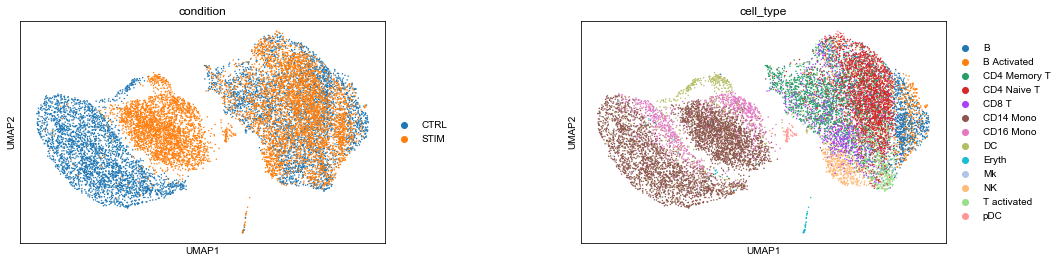

In [6]:
sc.pl.umap(adata_train, color=["condition", "cell_type"], wspace=.4)

## creating model object 

In [7]:
model = trvaep.CVAE(adata_train.n_vars, num_classes=n_conditions,
            encoder_layer_sizes=[128, 32], decoder_layer_sizes=[32, 128], latent_dim=10, alpha=0.0001,
            use_mmd=True, beta=10)

### Make a trainer object 

In [8]:
trainer = trvaep.Trainer(model, adata_train)

In [9]:
trainer.train_trvae(200, 512, early_patience=30)

Epoch 00/200 Batch 0000/23, Loss:  154.8524, rec_loss:  152.6335, KL_loss:    0.0002, MMD_loss:     2.2187
Epoch 00/200 Batch 0023/23, Loss:   50.5063, rec_loss:   48.4081, KL_loss:    0.0005, MMD_loss:     2.0976
Epoch 01/200 Batch 0000/23, Loss:   47.6372, rec_loss:   45.8707, KL_loss:    0.0006, MMD_loss:     1.7659
Epoch 01/200 Batch 0023/23, Loss:   39.7568, rec_loss:   38.4891, KL_loss:    0.0009, MMD_loss:     1.2667
Epoch 02/200 Batch 0000/23, Loss:   42.7005, rec_loss:   41.1369, KL_loss:    0.0009, MMD_loss:     1.5627
Epoch 02/200 Batch 0023/23, Loss:   39.3457, rec_loss:   38.1403, KL_loss:    0.0012, MMD_loss:     1.2041
Epoch 03/200 Batch 0000/23, Loss:   38.7922, rec_loss:   37.3139, KL_loss:    0.0012, MMD_loss:     1.4770
Epoch 03/200 Batch 0023/23, Loss:   37.6697, rec_loss:   36.2879, KL_loss:    0.0014, MMD_loss:     1.3803
Epoch 04/200 Batch 0000/23, Loss:   38.2387, rec_loss:   37.0504, KL_loss:    0.0016, MMD_loss:     1.1867
Epoch 04/200 Batch 0023/23, Loss:   3

## visualizing the MMD latent space

... storing 'cell_type' as categorical
... storing 'condition' as categorical


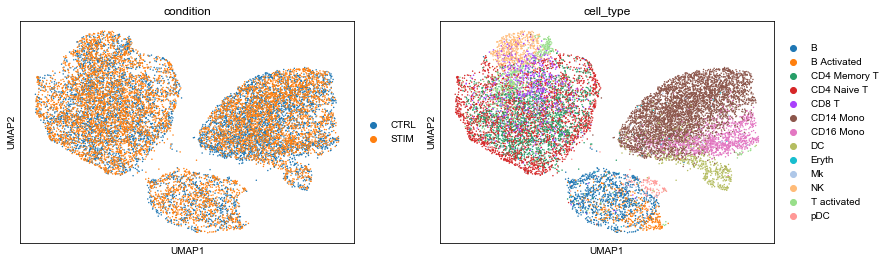

In [10]:
latent_y = model.get_y(
    adata.X.A, model.label_encoder.transform(adata.obs["condition"]))
adata_latent = sc.AnnData(latent_y)
adata_latent.obs["cell_type"] = adata.obs["cell_type"].tolist()
adata_latent.obs["condition"] = adata.obs["condition"].tolist()
sc.pp.neighbors(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent, color=["condition", "cell_type"])

## Making prediction

layers are inconsistent - only layers that are shared among all AnnData objects are included.
... storing 'cell_type' as categorical
... storing 'condition' as categorical
... storing 'orig.ident' as categorical
... storing 'seurat_annotations' as categorical
... storing 'stim' as categorical


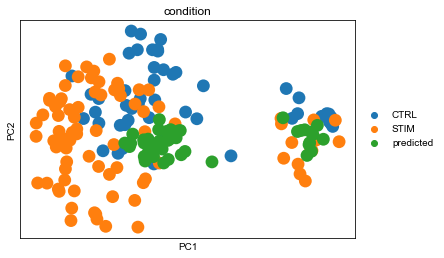

In [15]:
ground_truth = adata[(adata.obs["cell_type"] == "pDC")]
adata_source = adata[(adata.obs["cell_type"] == "pDC") &
                     (adata.obs["condition"] == "CTRL")]
predicted_data = model.predict(x=adata_source.X.A, y=adata_source.obs["condition"].tolist(),
                               target="STIM")
adata_pred = sc.AnnData(predicted_data)
adata_pred.obs["condition"] = np.tile("predicted", len(adata_pred))
adata_pred.var_names = adata_source.var_names.tolist()
all_adata = ground_truth.concatenate(adata_pred)
sc.tl.pca(all_adata)
sc.pl.pca(all_adata, color=["condition"])

## Mean correlation plot


In [16]:
sc.tl.rank_genes_groups(ground_truth, groupby="condition", method="wilcoxon")
diff_genes = ground_truth.uns["rank_genes_groups"]["names"]["STIM"]

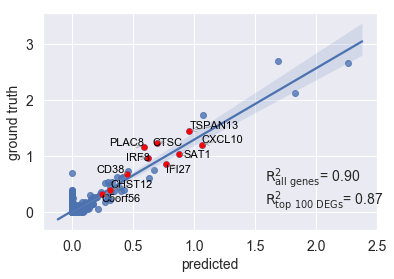

In [17]:
r2_value = pl.reg_mean_plot(all_adata, condition_key="condition",
                                        axis_keys={
                                            "x": "predicted", "y": "STIM"},
                                        gene_list=diff_genes[:10],
                                        top_100_genes= diff_genes,
                                        labels={"x": "predicted",
                                                "y": "ground truth"},
                                        path_to_save="./reg_mean1.pdf",
                                        show=True,
                                        legend=False)